In [3]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_RAW_PATH = "./data/calidad_de_vida/ocio/"
DATA_PROCESSED_PATH = "./data/processed"
DATA_APP_PATH = "../src/data/final"

# Load CABA Georeferences

<Axes: >

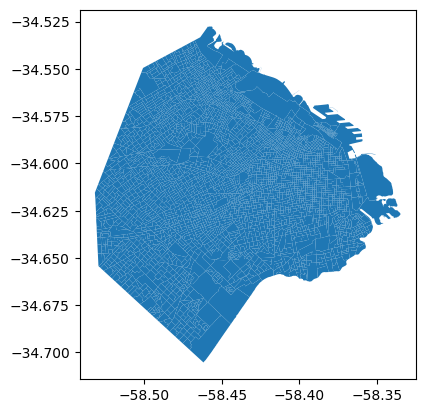

In [6]:
ciudad_gpd = gpd.read_file("res/radios-censales-geojson.json", driver='GeoJSON')
ciudad_gpd.plot()

In [172]:
def plot_over_caba(df, column, title, ax=None, ax_kwargs={},**kwargs):
    if not ax:
        ax = ciudad_gpd.plot(color='white', figsize=(10,10), **ax_kwargs)
    else:
        ciudad_gpd.plot(color='white', figsize=(10,10), ax=ax, **ax_kwargs)
    df.plot(column=column, ax=ax, legend=True, **kwargs)
    ax.set_title(title)
    return ax

<Axes: >

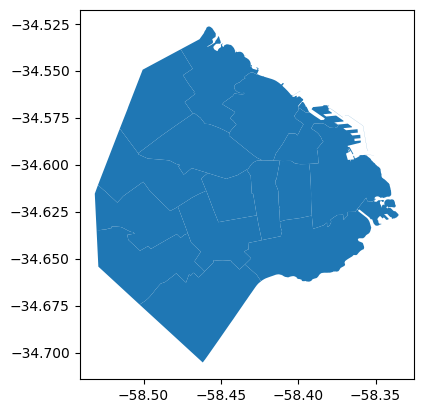

In [42]:
comunas = gpd.read_file("res/comunas-geojson.json", driver='GeoJSON')
comunas.plot()

# Polideportivos

## Load data

In [4]:
polideportivos_gpd = gpd.read_file(os.path.join(DATA_RAW_PATH, "polideportivos.geojson"), driver="GeoJSON")
polideportivos_gpd.info()
polideportivos_gpd.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   long        16 non-null     float64 
 1   lat         16 non-null     float64 
 2   id          16 non-null     int64   
 3   nom_polid   16 non-null     object  
 4   calle       16 non-null     object  
 5   nro         15 non-null     float64 
 6   telefono    15 non-null     object  
 7   domicilio   16 non-null     object  
 8   barrio      16 non-null     object  
 9   comuna      16 non-null     int64   
 10  hor_atenc   16 non-null     object  
 11  valor_ent   16 non-null     object  
 12  codigo_pos  11 non-null     float64 
 13  codigo_p_1  11 non-null     object  
 14  geometry    16 non-null     geometry
dtypes: float64(4), geometry(1), int64(2), object(8)
memory usage: 2.0+ KB


long        lat  id   nom_polid                    calle    nro  \
2 -58.444674 -34.579459   3  COLEGIALES  CAP. GRAL. RAMON FREIRE  120.0   

   telefono                    domicilio      barrio  comuna  \
2  45556838  120 CAP. GRAL. RAMON FREIRE  COLEGIALES      13   

                                           hor_atenc valor_ent  codigo_pos  \
2  Lunes a viernes de 8 a 21 horas y sábados, dom...  Gratuito      1426.0   

  codigo_p_1                     geometry  
2   C1426AYE  POINT (-58.44467 -34.57946)

<Axes: title={'center': 'Polideportivos'}>

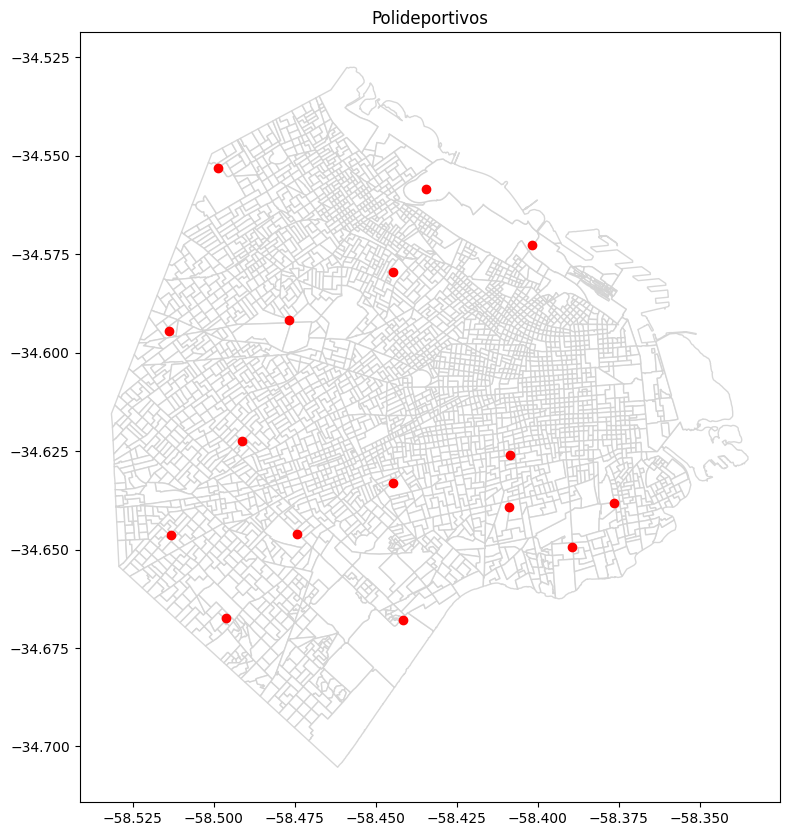

In [17]:
plot_over_caba(polideportivos_gpd, None, "Polideportivos", color="red", ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"})

<Axes: xlabel='anio'>

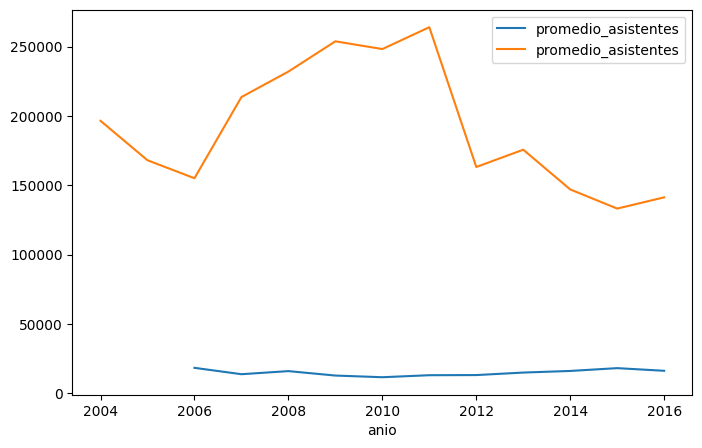

In [28]:
actividades_dirigidas_asistencia = pd.read_csv(os.path.join(DATA_RAW_PATH, "polideportivos_prom_asist_dir_sexo__annio_limpio.csv"))
actividades_libres_asistencia = pd.read_csv(os.path.join(DATA_RAW_PATH, "polideportivos_prom_asist_lib_sexo__annio_limpio.csv"))
fig, ax = plt.subplots(1,1, figsize=(8,5), sharex=True)
actividades_dirigidas_asistencia.groupby("anio").max().plot(ax=ax, label="Actividades dirigidas")
actividades_libres_asistencia.groupby("anio").max().plot(ax=ax, label="Actividades libres")
# NO hay datos desagregados por comuna o georef

In [29]:
actividades_asistencia_fem_dirigidas = pd.read_csv(os.path.join(DATA_RAW_PATH, "polideportivos_ind_fem_act_dir_annio_limpio.csv"))
actividades_asistencia_fem_dirigidas

anio  ind_fem_act_dirigidas
0   2006             123.396505
1   2007             136.547236
2   2008             112.177212
3   2009             115.115923
4   2010             124.188917
5   2011             122.200457
6   2012             117.209526
7   2013             119.866913
8   2014             117.289862
9   2015             135.865488
10  2016             141.698177
11  2017             133.662604
12  2018             128.700000
13  2019             137.100000

### Cálculo de quintil distancia a polideportivo

Similar que con las comisarías, voy a calcular cuán lejos están los distintos radios censales de cada polideportivo. Luego con eso puedo obtener métricas por comuna o directamente plotear los resultados.

In [32]:
distancia_a_polideportivos = ciudad_gpd.copy()
distancia_a_polideportivos.sample()

WKT    ID CO_FRAC_RA  \
1747  MULTIPOLYGON (((-58.4610460392885 -34.60237172...  1748     15_8_6   

     COMUNA FRACCION RADIO TOTAL_POB T_VARON T_MUJER T_VIVIENDA V_PARTICUL  \
1747     15        8     6       720     324     396        324        324   

     V_COLECTIV T_HOGAR H_CON_NBI H_SIN_NBI  \
1747          0     260         5       255   

                                               geometry  
1747  MULTIPOLYGON (((-58.46105 -34.60237, -58.46093...

/tmp/ipykernel_44634/4111599015.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distancia_a_polideportivos["distancia_polideportivo"] = distancia_a_polideportivos.geometry.apply(lambda x: polideportivos_gpd.distance(x).min())


<Axes: >

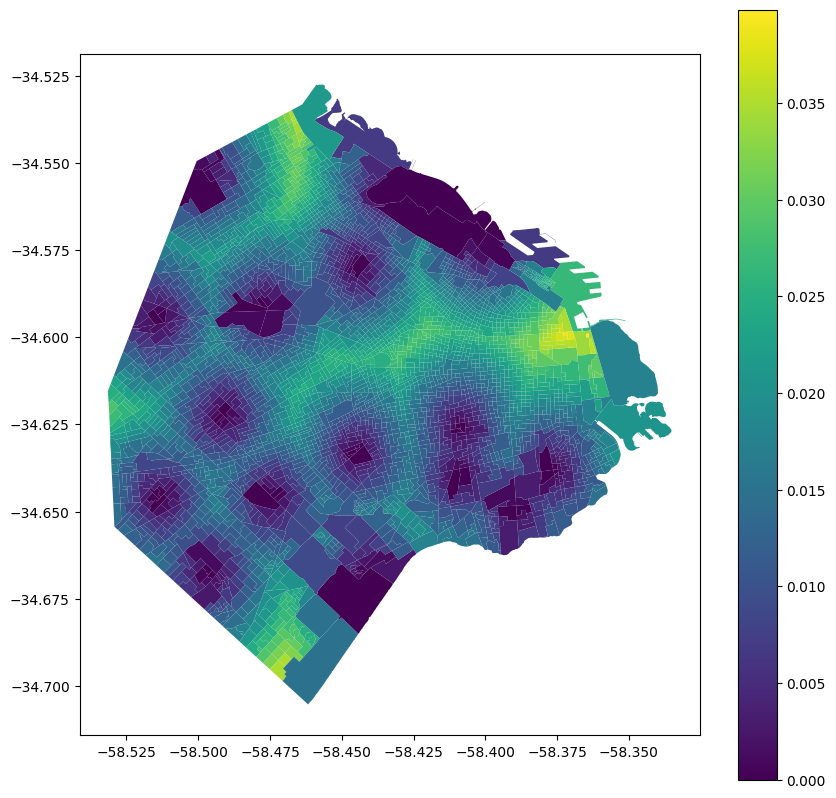

In [36]:
# nos aseguramos que la data de los polideportivos y los radios censales están en la misma proyección
polideportivos_gpd.to_crs(epsg=4326, inplace=True)
distancia_a_polideportivos.to_crs(epsg=4326, inplace=True)

# compute distance to nearest polideportivo
distancia_a_polideportivos["distancia_polideportivo"] = distancia_a_polideportivos.geometry.apply(lambda x: polideportivos_gpd.distance(x).min())
distancia_a_polideportivos.plot(column="distancia_polideportivo", legend=True, figsize=(10,10))

<Axes: title={'center': 'Polideportivos'}>

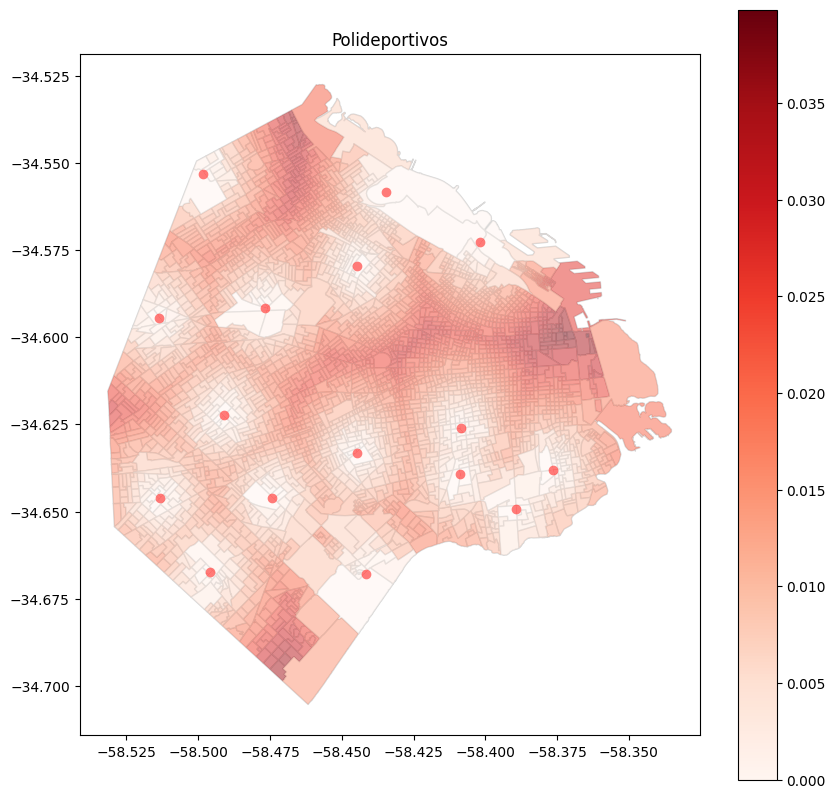

In [52]:
ax = plot_over_caba(polideportivos_gpd, None, "Polideportivos", color="red", ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"})
distancia_a_polideportivos.plot(column="distancia_polideportivo", legend=True, ax=ax, zorder=2, cmap="Reds", alpha=0.5)

<Axes: >

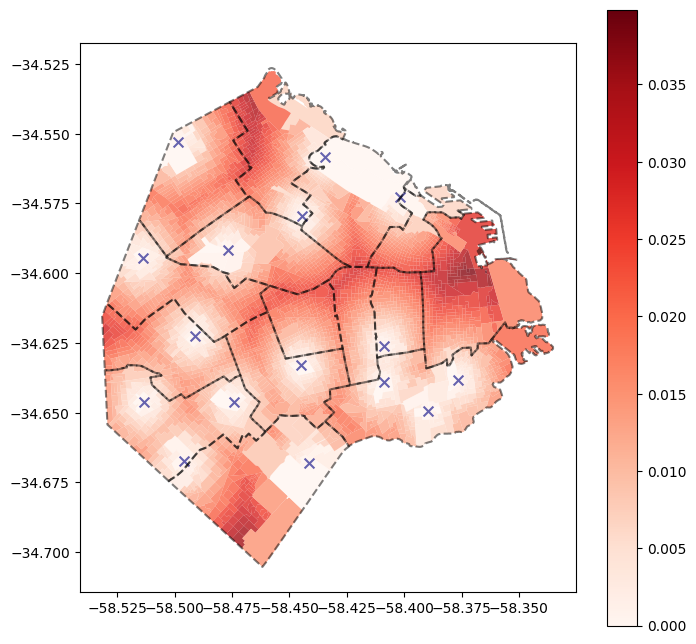

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,8), sharex=True)
comunas.geometry.boundary.plot(ax=ax, color="black", linestyle="--", alpha=.5)
distancia_a_polideportivos.plot(column="distancia_polideportivo", legend=True, ax=ax, cmap="Reds", alpha=0.8)
polideportivos_gpd.plot(ax=ax, color="navy", alpha=0.6, marker="x", markersize=50)

In [69]:
distancia_a_polideportivos.head()

WKT ID CO_FRAC_RA COMUNA  \
0  MULTIPOLYGON (((-58.372489764082 -34.591546570...  1      1_1_1      1   
1  MULTIPOLYGON (((-58.3865223305709 -34.60399309...  2     1_12_1      1   
2  MULTIPOLYGON (((-58.3793832787935 -34.60483817...  3    1_12_10      1   
3  MULTIPOLYGON (((-58.3679211414675 -34.60517426...  4    1_12_11      1   
4  MULTIPOLYGON (((-58.3851326494337 -34.60391158...  5     1_12_2      1   

  FRACCION RADIO TOTAL_POB T_VARON T_MUJER T_VIVIENDA V_PARTICUL V_COLECTIV  \
0        1     1       336     212     124         82         80          2   
1       12     1       341     184     157        365        361          4   
2       12    10       296     162     134        629        627          2   
3       12    11       528     294     234        375        370          5   
4       12     2       229     101     128        445        445          0   

  T_HOGAR H_CON_NBI H_SIN_NBI  \
0      65        19        46   
1     116        25        91   
2     101         1       100   
3     136         7       129   
4     129        16       113   

                                            geometry  distancia_polideportivo  
0  MULTIPOLYGON (((-58.37249 -34.59155, -58.37261...                 0.026699  
1  MULTIPOLYGON (((-58.38652 -34.60399, -58.38634...                 0.030356  
2  MULTIPOLYGON (((-58.37938 -34.60484, -58.37801...                 0.031724  
3  MULTIPOLYGON (((-58.36792 -34.60517, -58.36772...                 0.030267  
4  MULTIPOLYGON (((-58.38513 -34.60391, -58.38371...                 0.031479

In [70]:
# get quintiles
distancia_a_polideportivos["quintil_distancia_polideportivo"] = pd.qcut(distancia_a_polideportivos["distancia_polideportivo"], 5, labels=False) + 1
distancia_a_polideportivos.quintil_distancia_polideportivo.value_counts()

5    711
4    711
2    711
1    711
3    710
Name: quintil_distancia_polideportivo, dtype: int64

<Axes: title={'center': 'Distancia a polideportivos'}>

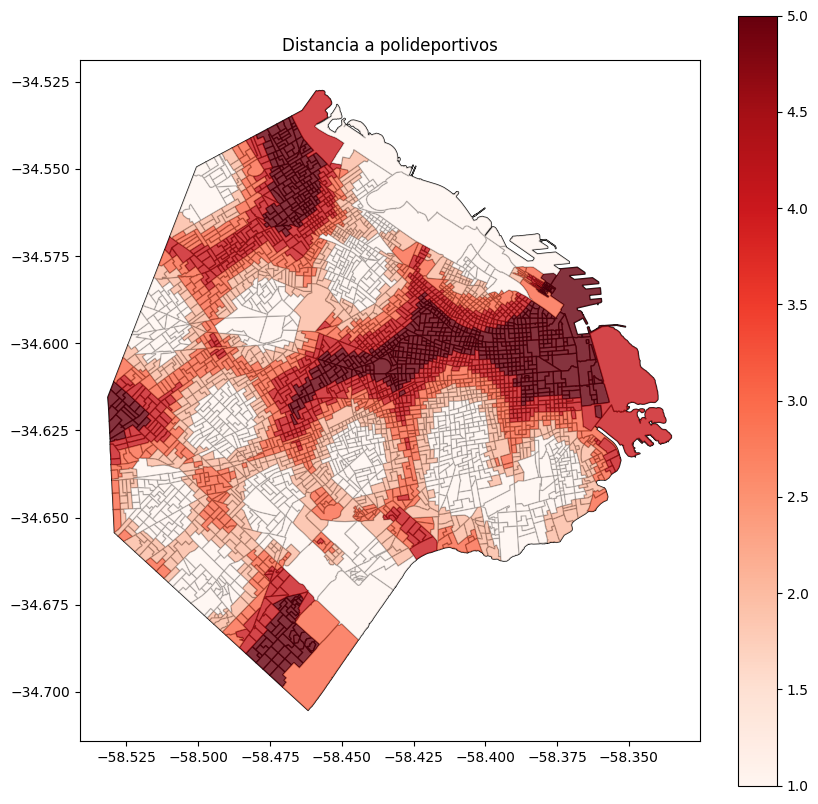

In [77]:
# distancia_a_polideportivos.plot(column="quintil_distancia_polideportivo", legend=True, figsize=(10,10), cmap="Reds")
plot_over_caba(distancia_a_polideportivos, "quintil_distancia_polideportivo", "Distancia a polideportivos", cmap="Reds", figsize=(10,10), zorder=2, alpha=.8, ax_kwargs={"alpha":0.9, "edgecolor": "black"})

<Axes: xlabel='quintil_distancia_polideportivo', ylabel='COMUNA'>

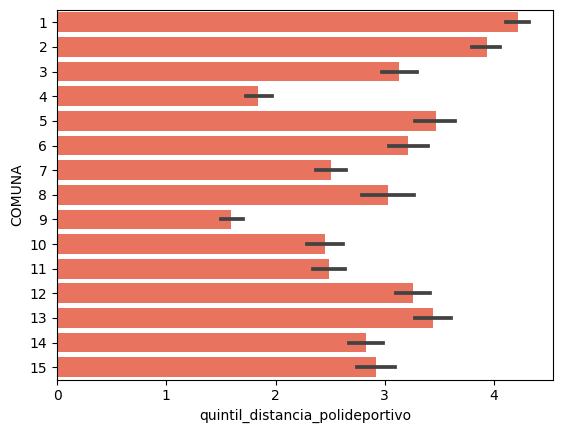

In [92]:
distancia_a_polideportivos.COMUNA = distancia_a_polideportivos.COMUNA.astype(int)
# distancia_a_polideportivos.groupby("COMUNA").quintil_distancia_polideportivo.mean().sort_index(ascending=False).plot(kind="barh")
sns.barplot(
    data=distancia_a_polideportivos,
    x="quintil_distancia_polideportivo",
    y="COMUNA",orient="h",
    color="tomato",
)

In [94]:
distancia_a_polideportivos[["ID", "CO_FRAC_RA", "distancia_polideportivo", "quintil_distancia_polideportivo", "geometry"]].to_file(os.path.join(DATA_PROCESSED_PATH, "distancia_polideportivos.geojson"), driver="GeoJSON")

# Juegotecas

In [95]:
juegotecas = gpd.read_file(os.path.join(DATA_RAW_PATH, "juegotecas.geojson"), driver="GeoJSON")
juegotecas.info()
juegotecas.sample(4)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_usig     19 non-null     int64   
 1   direccion   19 non-null     object  
 2   categoria   19 non-null     object  
 3   tipo        19 non-null     object  
 4   nombre_org  19 non-null     object  
 5   nombre      19 non-null     object  
 6   destinatar  18 non-null     object  
 7   telefono    1 non-null      object  
 8   mail        0 non-null      float64 
 9   horario     6 non-null      object  
 10  link_web    17 non-null     object  
 11  direccion_  18 non-null     object  
 12  barrio      18 non-null     object  
 13  comuna      18 non-null     object  
 14  geometry    19 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(12)
memory usage: 2.4+ KB


id_usig                         direccion        categoria  \
13      143                  Pi y Margall 671  Establecimiento   
3       155                 Félix Origone 946  Establecimiento   
7       153  Av. Piedra Buena 3140 - Villa 15  Establecimiento   
4       156                 Tres Arroyos 3037  Establecimiento   

                    tipo nombre_org      nombre            destinatar  \
13  JUEGOTECAS BARRIALES      DGNyA   Catalinas  Mixto de 3 a 13 años   
3   JUEGOTECAS BARRIALES      DGNyA     Liniers  Mixto de 3 a 13 años   
7   JUEGOTECAS BARRIALES      DGNyA  Aventurera  Mixto de 3 a 13 años   
4   JUEGOTECAS BARRIALES      DGNyA  Santa Rita  Mixto de 3 a 13 años   

   telefono  mail       horario  \
13      NaN   NaN           NaN   
3       NaN   NaN           NaN   
7       NaN   NaN  Turno mañana   
4       NaN   NaN           NaN   

                                             link_web  \
13  http://www.buenosaires.gob.ar/desarrollohumano...   
3   http://www.buenosaires.gob.ar/desarrollohumano...   
7   http://www.buenosaires.gob.ar/desarrollohumano...   
4   http://www.buenosaires.gob.ar/desarrollohumano...   

                        direccion_            barrio comuna  \
13                PI Y MARGALL 671              BOCA      4   
3   ORIGONE, MANUEL FELIX, TTE 946           LINIERS      9   
7            PIEDRA BUENA AV. 3140      VILLA LUGANO      8   
4                TRES ARROYOS 3037  VILLA SANTA RITA     11   

                       geometry  
13  POINT (-58.36549 -34.62695)  
3   POINT (-58.52499 -34.64929)  
7   POINT (-58.49266 -34.66726)  
4   POINT (-58.47851 -34.61823)

<Axes: title={'center': 'Juegotecas'}>

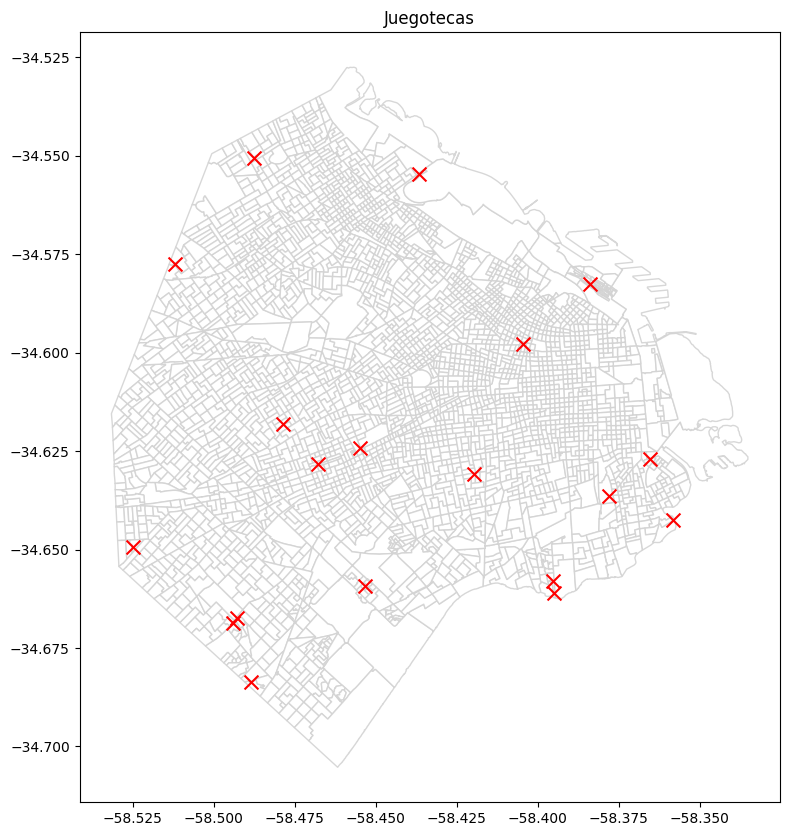

In [97]:
plot_over_caba(juegotecas, None, "Juegotecas", color="red", marker="x", markersize=100, ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"})

In [98]:
# computo distancias de cada RA a la juegoteca más cercana
juegotecas.to_crs(epsg=4326, inplace=True)
distancia_a_juegotecas = ciudad_gpd.copy()

distancia_a_juegotecas["distancia_juegoteca"] = distancia_a_juegotecas.geometry.apply(lambda x: juegotecas.distance(x).min())
# tomo el quintil
distancia_a_juegotecas["quintil_distancia_juegoteca"] = pd.qcut(distancia_a_juegotecas["distancia_juegoteca"], 5, labels=False) + 1
distancia_a_juegotecas.quintil_distancia_juegoteca.value_counts()

/tmp/ipykernel_44634/1259396866.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distancia_a_juegotecas["distancia_juegoteca"] = distancia_a_juegotecas.geometry.apply(lambda x: juegotecas.distance(x).min())


1    711
4    711
5    711
2    711
3    710
Name: quintil_distancia_juegoteca, dtype: int64

<Axes: >

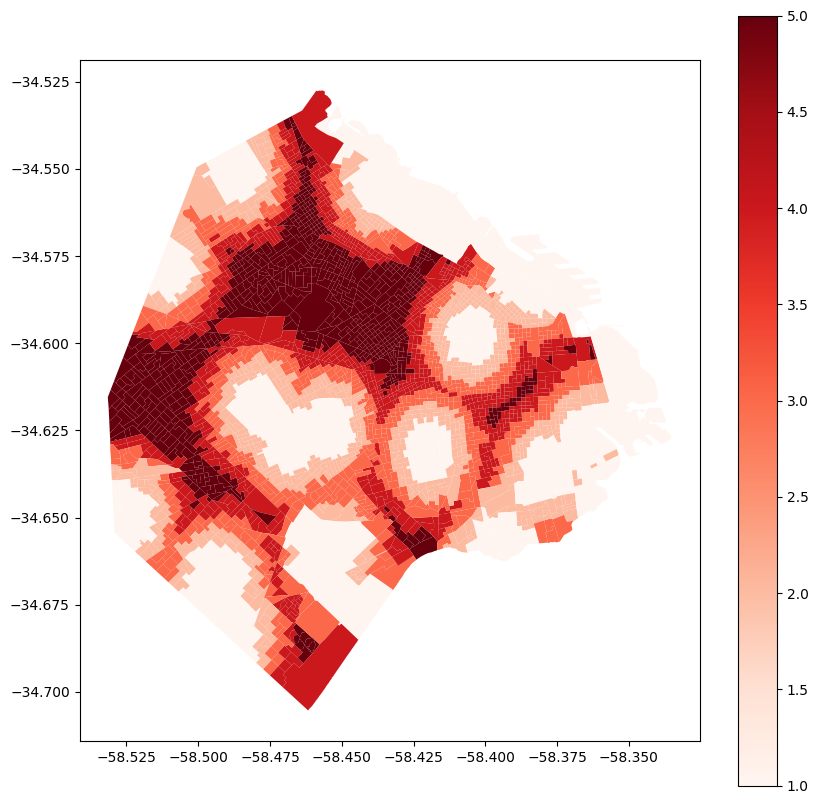

In [100]:
distancia_a_juegotecas.plot(column="quintil_distancia_juegoteca", legend=True, figsize=(10,10), cmap="Reds")

Text(0.5, 1.0, 'Polideportivos')

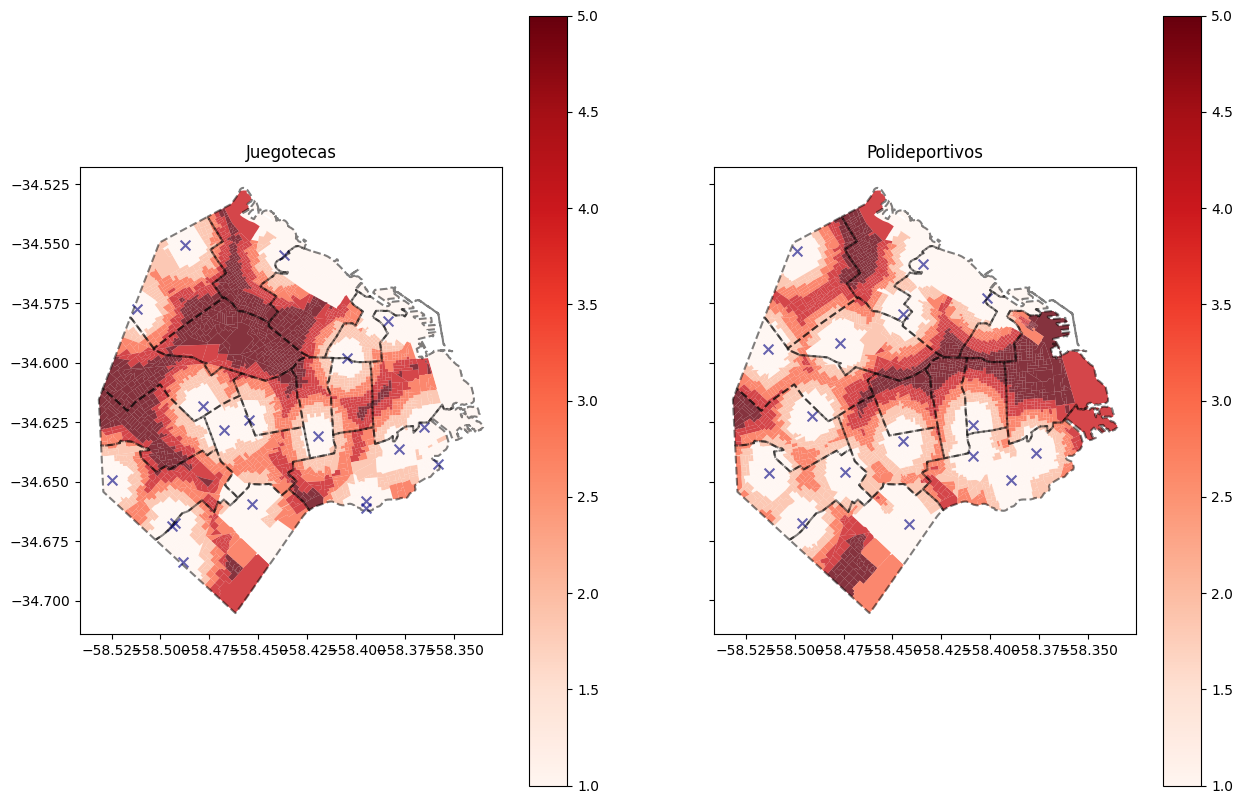

In [101]:
# plot quintiles de distancia juegotecas y polideportivos side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)
comunas.geometry.boundary.plot(ax=ax1, color="black", linestyle="--", alpha=.5)
comunas.geometry.boundary.plot(ax=ax2, color="black", linestyle="--", alpha=.5)
distancia_a_juegotecas.plot(column="quintil_distancia_juegoteca", legend=True, ax=ax1, cmap="Reds", alpha=0.8)
distancia_a_polideportivos.plot(column="quintil_distancia_polideportivo", legend=True, ax=ax2, cmap="Reds", alpha=0.8)
juegotecas.plot(ax=ax1, color="navy", alpha=0.6, marker="x", markersize=50)
polideportivos_gpd.plot(ax=ax2, color="navy", alpha=0.6, marker="x", markersize=50)
ax1.set_title("Juegotecas")
ax2.set_title("Polideportivos")



In [102]:
distancia_a_juegotecas[["ID", "CO_FRAC_RA", "distancia_juegoteca", "quintil_distancia_juegoteca", "geometry"]].to_file(os.path.join(DATA_PROCESSED_PATH, "distancia_juegotecas.geojson"), driver="GeoJSON")

In [104]:
df_distancias_calidad_vida = pd.merge(distancia_a_juegotecas[["geometry","ID", "CO_FRAC_RA", "distancia_juegoteca", "quintil_distancia_juegoteca"]], distancia_a_polideportivos[["ID", "CO_FRAC_RA", "distancia_polideportivo", "quintil_distancia_polideportivo"]], on=["ID", "CO_FRAC_RA"])
df_distancias_calidad_vida.head()

geometry ID CO_FRAC_RA  \
0  MULTIPOLYGON (((-58.37249 -34.59155, -58.37261...  1      1_1_1   
1  MULTIPOLYGON (((-58.38652 -34.60399, -58.38634...  2     1_12_1   
2  MULTIPOLYGON (((-58.37938 -34.60484, -58.37801...  3    1_12_10   
3  MULTIPOLYGON (((-58.36792 -34.60517, -58.36772...  4    1_12_11   
4  MULTIPOLYGON (((-58.38513 -34.60391, -58.38371...  5     1_12_2   

   distancia_juegoteca  quintil_distancia_juegoteca  distancia_polideportivo  \
0             0.006648                            1                 0.026699   
1             0.019165                            4                 0.030356   
2             0.021726                            5                 0.031724   
3             0.019864                            4                 0.030267   
4             0.020462                            4                 0.031479   

   quintil_distancia_polideportivo  
0                                5  
1                                5  
2                                5  
3                                5  
4                                5

<Axes: >

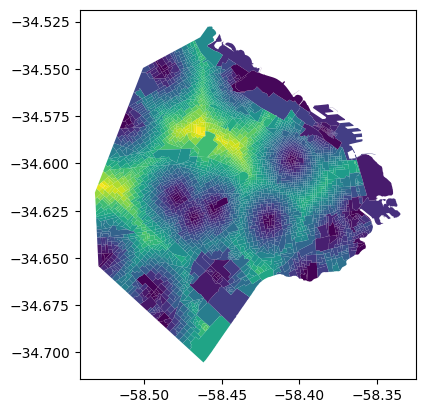

In [106]:
df_distancias_calidad_vida.plot(column="distancia_juegoteca")

# Actividades Culturales

In [162]:
actividades_culturales_2020 = gpd.read_file(os.path.join(DATA_RAW_PATH, "actividades_culturales_2020.geojson"), driver="GeoJSON")
actividades_culturales_2021 = gpd.read_file(os.path.join(DATA_RAW_PATH, "actividades_culturales_2021.geojson"), driver="GeoJSON")

actividades_culturales_2021.head()

Modalidad                                      actividad  \
0  Presencial  Verano de Cine Nacional: Mamá se fue de viaje   
1     Virtual                                    Libro Móvil   
2     Virtual                                 Instalar Danza   
3  Presencial                Verano de Cine Nacional: Betibú   
4     Virtual  Concurso Desarrollo de Proyectos Audiovisuale   

                               descripcion_actividad  \
0  Ciclo de cine nacional al aire libre con una p...   
1  Una vidriera de libros nómade en el espacio pú...   
2  Ciclo de danza online a través de Vivamos Cult...   
3  Ciclo de cine nacional al aire libre con una p...   
4  Concurso de desarrollo de proyectos audiovisua...   

                                               lugar  \
0                                  CLUB ARQUITECTURA   
1  distintas ferias de la ciudad y espacios verde...   
2                                                NaN   
3                                  CLUB ARQUITECTURA   
4                                                  -   

                   dirección                calle  altura     barrio comuna  \
0  BEIRO, FRANCISCO AV. 2116  BEIRO, FRANCISCO AV  2116.0  AGRONOMIA     15   
1                        NaN                  NaN     NaN        NaN    NaN   
2                        NaN                  NaN     NaN        NaN    NaN   
3  BEIRO, FRANCISCO AV. 2116  BEIRO, FRANCISCO AV  2116.0  AGRONOMIA     15   
4                        NaN                  NaN     NaN        NaN    NaN   

    fecha_ini   fecha_fin          tipo        tipo_actividad  \
0   9/11/2021   9/11/2021     Actividad  Función / Exhibición   
1   13/1/2021    6/3/2021     Actividad                 Ciclo   
2   15/1/2021   15/2/2021     Actividad                 Ciclo   
3  16/11/2021  16/11/2021     Actividad  Función / Exhibición   
4   20/1/2021   19/2/2021  Convocatoria                   NaN   

                    disciplina publico_objetivo se_suspende_por_lluvia  \
0           Cine y Audiovisual  Público General                     Si   
1  Literatura, Libro y Lectura  Público General                     Si   
2              Artes Escénicas  Público General                     No   
3           Cine y Audiovisual  Público General                     Si   
4           Cine y Audiovisual  Público General                     No   

  Gratuita       long        lat  \
0       Si -58.485091 -34.589483   
1       Si        NaN        NaN   
2       Si        NaN        NaN   
3       Si -58.485091 -34.589483   
4       Si        NaN        NaN   

                                               Links  field_21  \
0                                                NaN       NaN   
1  https://www.buenosaires.gob.ar/cultura/impulso...       NaN   
2  https://vivamoscultura.buenosaires.gob.ar/cont...       NaN   
3                                                NaN       NaN   
4                           https://bacacluster.com/       NaN   

                      geometry  
0  POINT (-58.48509 -34.58948)  
1                         None  
2                         None  
3  POINT (-58.48509 -34.58948)  
4                         None

In [163]:
actividades_culturales_2021.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Modalidad               2920 non-null   object  
 1   actividad               2920 non-null   object  
 2   descripcion_actividad   1334 non-null   object  
 3   lugar                   2412 non-null   object  
 4   dirección               2228 non-null   object  
 5   calle                   2169 non-null   object  
 6   altura                  2154 non-null   float64 
 7   barrio                  2189 non-null   object  
 8   comuna                  2211 non-null   object  
 9   fecha_ini               2891 non-null   object  
 10  fecha_fin               2894 non-null   object  
 11  tipo                    2920 non-null   object  
 12  tipo_actividad          2793 non-null   object  
 13  disciplina              2898 non-null   object  
 14  publico_objetivo

<Axes: title={'center': 'Cantidad EC'}>

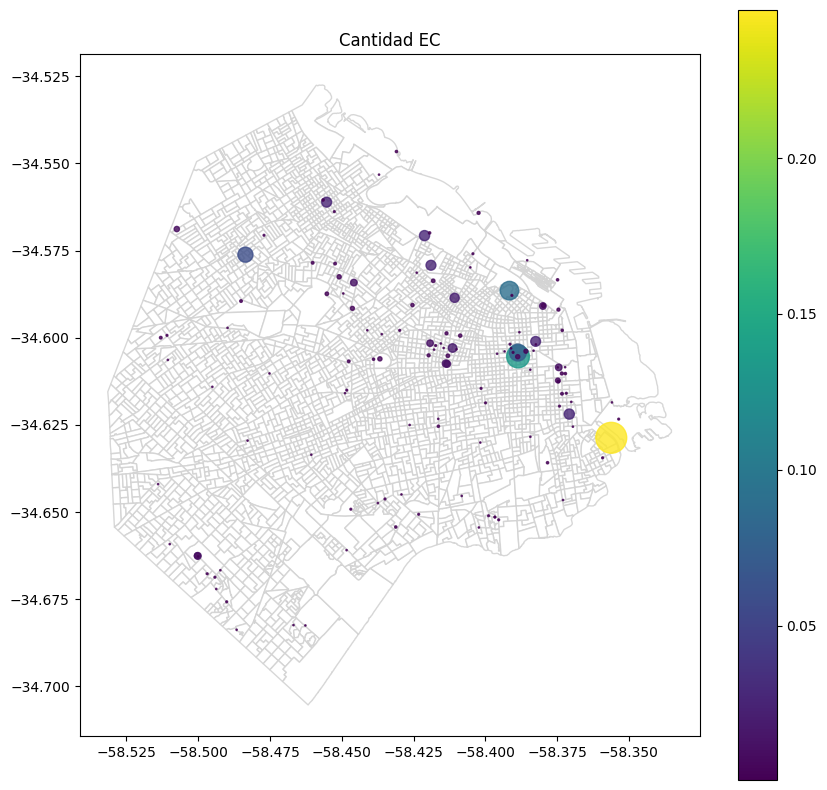

In [164]:
aux = actividades_culturales_2021.geometry.value_counts(normalize=True)
aux = aux.to_frame().reset_index()
aux.columns = ["geometry", "cantidad_eventos"]
aux = gpd.GeoDataFrame(aux, geometry="geometry")
aux.set_crs(epsg=4326, inplace=True)
plot_over_caba(aux, "cantidad_eventos", "Cantidad EC", ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"}, figsize=(10,10), zorder=2, alpha=.8, markersize=aux.cantidad_eventos*2000)
# aux = gpd.GeoDataFrame(aux, geometry=gpd.points_from_xy(aux.index.get_level_values(1), aux.index.get_level_values(0)))

In [165]:
# cuáles son los espacios culturales con más actividad?
actividades_culturales_2021.groupby("lugar").size().sort_values(ascending=False).head(10)

lugar
USINA DEL ARTE                           546
CENTRO CULTURAL GENERAL SAN MARTIN       288
CENTRO CULTURAL RECOLETA                 197
TEATRO SAN MARTÍN                        164
CENTRO CULTURAL 25 DE MAYO               130
vivamos cultura                           89
MUSEO SÍVORI                              59
MUSEO DE ARTE MODERNO DE BUENOS AIRES     57
TEATRO SARMIENTO                          56
MUSEO DE ARTE ESPAÑOL ENRIQUE LARRETA     55
dtype: int64

<Axes: title={'center': 'Actividades Culturales 2021'}>

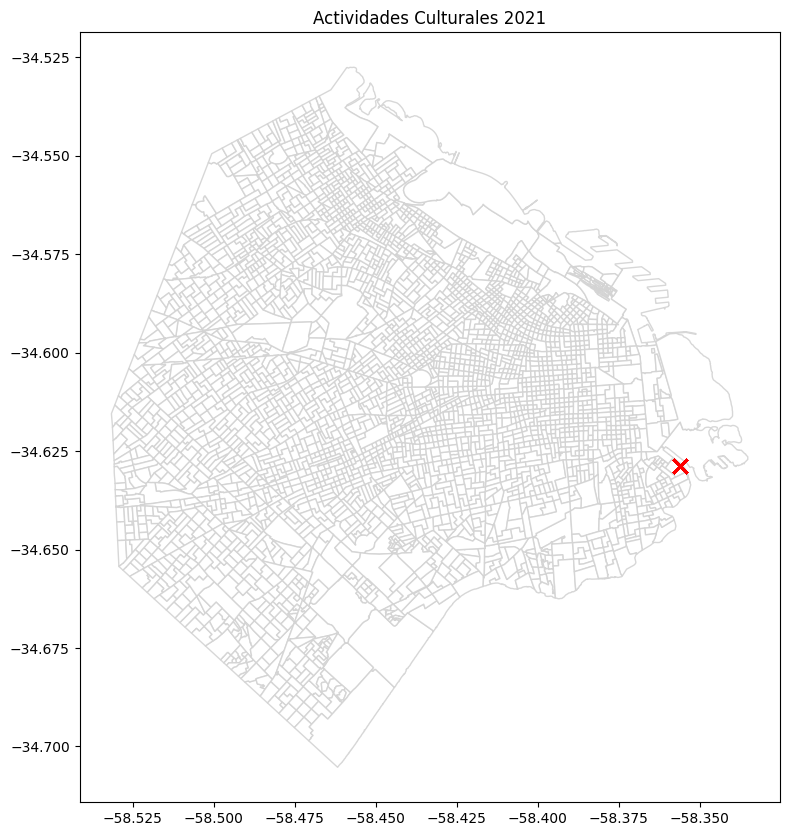

In [166]:
plot_over_caba(actividades_culturales_2021.dropna(subset=["lugar"])[actividades_culturales_2021.dropna(subset=["lugar"]).lugar.str.contains("USINA")], None, "Actividades Culturales 2021", color="red", marker="x", markersize=100, ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"})

In [167]:
pd.set_option("display.max_columns", 100 )

In [168]:
actividades_culturales_2021.head()

Modalidad                                      actividad  \
0  Presencial  Verano de Cine Nacional: Mamá se fue de viaje   
1     Virtual                                    Libro Móvil   
2     Virtual                                 Instalar Danza   
3  Presencial                Verano de Cine Nacional: Betibú   
4     Virtual  Concurso Desarrollo de Proyectos Audiovisuale   

                               descripcion_actividad  \
0  Ciclo de cine nacional al aire libre con una p...   
1  Una vidriera de libros nómade en el espacio pú...   
2  Ciclo de danza online a través de Vivamos Cult...   
3  Ciclo de cine nacional al aire libre con una p...   
4  Concurso de desarrollo de proyectos audiovisua...   

                                               lugar  \
0                                  CLUB ARQUITECTURA   
1  distintas ferias de la ciudad y espacios verde...   
2                                                NaN   
3                                  CLUB ARQUITECTURA   
4                                                  -   

                   dirección                calle  altura     barrio comuna  \
0  BEIRO, FRANCISCO AV. 2116  BEIRO, FRANCISCO AV  2116.0  AGRONOMIA     15   
1                        NaN                  NaN     NaN        NaN    NaN   
2                        NaN                  NaN     NaN        NaN    NaN   
3  BEIRO, FRANCISCO AV. 2116  BEIRO, FRANCISCO AV  2116.0  AGRONOMIA     15   
4                        NaN                  NaN     NaN        NaN    NaN   

    fecha_ini   fecha_fin          tipo        tipo_actividad  \
0   9/11/2021   9/11/2021     Actividad  Función / Exhibición   
1   13/1/2021    6/3/2021     Actividad                 Ciclo   
2   15/1/2021   15/2/2021     Actividad                 Ciclo   
3  16/11/2021  16/11/2021     Actividad  Función / Exhibición   
4   20/1/2021   19/2/2021  Convocatoria                   NaN   

                    disciplina publico_objetivo se_suspende_por_lluvia  \
0           Cine y Audiovisual  Público General                     Si   
1  Literatura, Libro y Lectura  Público General                     Si   
2              Artes Escénicas  Público General                     No   
3           Cine y Audiovisual  Público General                     Si   
4           Cine y Audiovisual  Público General                     No   

  Gratuita       long        lat  \
0       Si -58.485091 -34.589483   
1       Si        NaN        NaN   
2       Si        NaN        NaN   
3       Si -58.485091 -34.589483   
4       Si        NaN        NaN   

                                               Links  field_21  \
0                                                NaN       NaN   
1  https://www.buenosaires.gob.ar/cultura/impulso...       NaN   
2  https://vivamoscultura.buenosaires.gob.ar/cont...       NaN   
3                                                NaN       NaN   
4                           https://bacacluster.com/       NaN   

                      geometry  
0  POINT (-58.48509 -34.58948)  
1                         None  
2                         None  
3  POINT (-58.48509 -34.58948)  
4                         None

In [169]:
actividades_culturales_2021.Gratuita.value_counts()

si           1188
Gratuito      853
no            368
Pago          275
Si            235
Gratutito       1
Name: Gratuita, dtype: int64

In [170]:
# limpio la columna para saber si cada evento es gratuito o no
actividades_culturales_2021.rename(columns={"Gratuita": "gratuita"}, inplace=True)
actividades_culturales_2021.gratuita = actividades_culturales_2021.gratuita.str.lower()
actividades_culturales_2021.replace({"gratuita": {"si": True, "no": False, "gratuito":True, "gratutito": True, "pago": False}}, inplace=True)
actividades_culturales_2021.gratuita.value_counts()

True     2277
False     643
Name: gratuita, dtype: int64

/home/juanse/anaconda3/envs/dataanalysis/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/juanse/anaconda3/envs/dataanalysis/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Axes: title={'center': 'Cantidad EC Pagos'}>

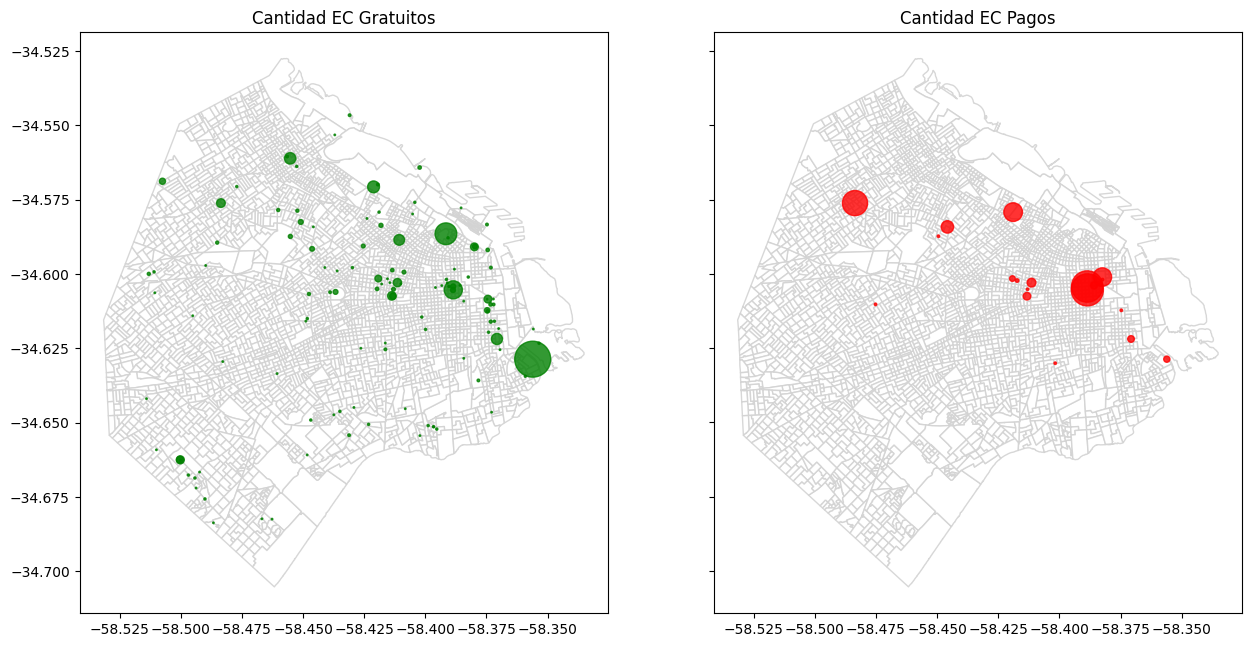

In [173]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)

aux = actividades_culturales_2021[actividades_culturales_2021.gratuita].geometry.value_counts(normalize=True)
aux = aux.to_frame().reset_index()
aux.columns = ["geometry", "cantidad_eventos"]
aux = gpd.GeoDataFrame(aux, geometry="geometry")
aux.set_crs(epsg=4326, inplace=True)
plot_over_caba(aux, "cantidad_eventos", "Cantidad EC Gratuitos", ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"}, figsize=(10,10), zorder=2, alpha=.8, markersize=aux.cantidad_eventos*2000, ax=ax1, color="green")


aux = actividades_culturales_2021[~actividades_culturales_2021.gratuita].geometry.value_counts(normalize=True)
aux = aux.to_frame().reset_index()
aux.columns = ["geometry", "cantidad_eventos"]
aux = gpd.GeoDataFrame(aux, geometry="geometry")
aux.set_crs(epsg=4326, inplace=True)
plot_over_caba(aux, "cantidad_eventos", "Cantidad EC Pagos", ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"}, figsize=(10,10), zorder=2, alpha=.8, markersize=aux.cantidad_eventos*2000, ax=ax2, color="red")

<Axes: title={'center': 'Cantidad EC Gratuitos'}>

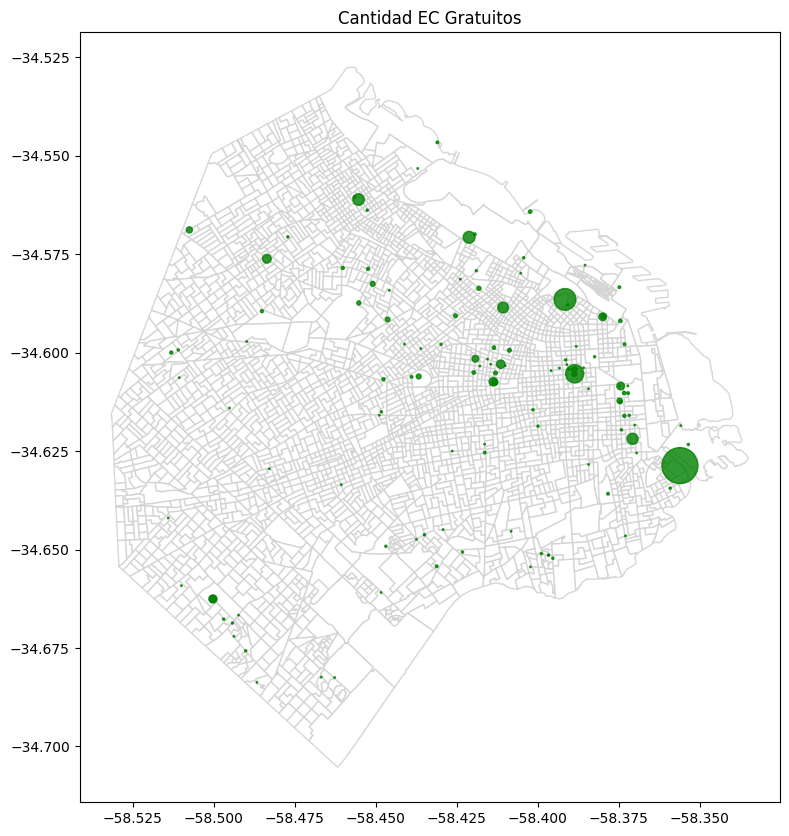

In [190]:
recuento_actividades_gratuitas = actividades_culturales_2021[actividades_culturales_2021.gratuita].geometry.value_counts(normalize=True)
recuento_actividades_gratuitas = recuento_actividades_gratuitas.to_frame().reset_index()
recuento_actividades_gratuitas.columns = ["geometry", "cantidad_eventos"]
recuento_actividades_gratuitas = gpd.GeoDataFrame(recuento_actividades_gratuitas, geometry="geometry")
recuento_actividades_gratuitas.set_crs(epsg=4326, inplace=True)
plot_over_caba(recuento_actividades_gratuitas,None, "Cantidad EC Gratuitos",
                                    ax_kwargs={"alpha":0.9, "edgecolor": "lightgrey"},
                                    color="green", alpha=0.8, markersize=recuento_actividades_gratuitas.cantidad_eventos*2000,)

In [191]:
actividades_culturales_2021.sample(5)

Modalidad                                       actividad  \
1268     Virtual               Ciudanza Proyectos Audiovisualles   
37    Presencial                                           Vacío   
1265     Virtual         Videoclips de tango bailado. Videodanza   
807   Presencial  Taller de breaking por Luciérnagas de la Calle   
1069  Presencial            Freakshow, feria de fenómenos y rock   

                                  descripcion_actividad  \
1268  Convocatoria a creaciones de danza en formato ...   
37                   Dirección de Diego Sebastián Oria.   
1265  Concursan videos de parejas de tango escenario...   
807   Un espacio de confianza y compañerismo propici...   
1069         Show musical por Panceta y los papafritas.   

                                   lugar                dirección  \
1268                    web buenos aires                      NaN   
37    CENTRO CULTURAL GENERAL SAN MARTIN           SARMIENTO 1551   
1265                    web buenos aires                      NaN   
807                       USINA DEL ARTE  CAFFARENA, AGUSTIN R. 1   
1069  CENTRO CULTURAL GENERAL SAN MARTIN           SARMIENTO 1551   

                      calle  altura       barrio comuna  fecha_ini  fecha_fin  \
1268                    NaN     NaN          NaN    NaN  24/6/2021  25/7/2021   
37                SARMIENTO  1551.0  SAN NICOLAS      1  12/2/2021  12/2/2021   
1265                    NaN     NaN          NaN    NaN  30/6/2021   1/8/2021   
807   CAFFARENA, AGUSTIN R.     1.0         BOCA      4  13/3/2021  13/3/2021   
1069              SARMIENTO  1551.0  SAN NICOLAS      1  10/4/2021  10/4/2021   

              tipo        tipo_actividad  \
1268  Convocatoria                   NaN   
37       Actividad  Función / Exhibición   
1265  Convocatoria                   NaN   
807      Formación             Formación   
1069     Actividad   Concierto / Recital   

                                             disciplina  \
1268                                    Artes Escénicas   
37                                      Artes Escénicas   
1265  Cultura Tradicional Popular y Patrimonio Inmat...   
807                                               Otros   
1069                                             Música   

             publico_objetivo se_suspende_por_lluvia  gratuita       long  \
1268          Público General                     No      True        NaN   
37            Público General                     No      True -58.388586   
1265          Público General                     No      True        NaN   
807   Pre-adolescentes (8-12)                      0      True -58.356101   
1069              Niños (4-7)                     No     False -58.388586   

            lat                            Links  field_21  \
1268        NaN                              NaN       NaN   
37   -34.605371  http://elculturalsanmartin.org/       NaN   
1265        NaN                              NaN       NaN   
807  -34.628692                              NaN       NaN   
1069 -34.605371           elculturalsanmartin.ar       NaN   

                         geometry  
1268                         None  
37    POINT (-58.38859 -34.60537)  
1265                         None  
807   POINT (-58.35610 -34.62869)  
1069  POINT (-58.38859 -34.60537)

In [192]:
# me quedo solo con las actividades culturales que tienen lugar asociado
actividades_culturales_2021.dropna(subset=["geometry"], inplace=True)

In [193]:
actividades_culturales_2021.tipo_actividad.value_counts(dropna=False)

Función / Exhibición    916
Encuentro               350
Formación               252
Ciclo                   230
Concierto / Recital     184
Visita / Recorrido      101
Feria                    67
Exposición               55
Festival                 33
NaN                      24
Fiesta popular            2
Name: tipo_actividad, dtype: int64

In [194]:
actividades_culturales_2021.publico_objetivo.value_counts(dropna=False)

Público General            1243
Pre-adolescentes (8-12)     386
Niños (4-7)                 274
Primera infancia (0-3)      157
Jóvenes (13-21)             153
0                             1
Name: publico_objetivo, dtype: int64

In [195]:
actividades_culturales_2021["actividad_joven"] = ~actividades_culturales_2021.publico_objetivo.str.contains("general", case=False)
actividades_culturales_2021.actividad_joven.value_counts()

False    1243
True      971
Name: actividad_joven, dtype: int64

In [196]:
# filtro variables de interés
actividades_culturales_2021 = actividades_culturales_2021[["geometry", "lugar", "actividad_joven", "gratuita"]]
actividades_culturales_2021.head()

geometry              lugar  actividad_joven  gratuita
0  POINT (-58.48509 -34.58948)  CLUB ARQUITECTURA            False      True
3  POINT (-58.48509 -34.58948)  CLUB ARQUITECTURA            False      True
5  POINT (-58.48509 -34.58948)  CLUB ARQUITECTURA            False      True
6  POINT (-58.48509 -34.58948)  CLUB ARQUITECTURA            False      True
7  POINT (-58.41141 -34.60294)             ABASTO            False      True

In [209]:
# Computo distancias a los lugares que tienen actividades culturales en 2021
lugares_culturales_2021 = actividades_culturales_2021[["lugar", "geometry"]].drop_duplicates()
distancia_lugares_culturales = ciudad_gpd.copy()

# build a geodataframe containing, in each row, the elements in ciudad_gpd and the lugares in lugares_culturales_2021, computing hte distance between each of them
# first check they have the same CRS
distancia_lugares_culturales.set_crs(epsg=4326, inplace=True)
lugares_culturales_2021.set_crs(epsg=4326, inplace=True)

distancia_lugares_culturales = gpd.GeoDataFrame(distancia_lugares_culturales[["ID", "geometry", "CO_FRAC_RA"]].assign(key=1).merge(lugares_culturales_2021.assign(key=1), on="key", suffixes=("_ciudad", "_lugar")))
distancia_lugares_culturales.drop(columns=["key"], inplace=True) # hasta aca tengo el outer join de los dos dfs
# computar distancia entre cada lugar y cada lugar cultural
distancia_lugares_culturales["distancia"] = distancia_lugares_culturales.geometry_ciudad.distance(distancia_lugares_culturales.geometry_lugar)

# filtrar los 5 lugares culturales más cercanos a cada CO_FRAC_RA
distancia_lugares_culturales = distancia_lugares_culturales.sort_values(by=["CO_FRAC_RA", "distancia"]).groupby("CO_FRAC_RA").head(5)
distancia_lugares_culturales.head(5)

/tmp/ipykernel_44634/300213038.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distancia_lugares_culturales["distancia"] = distancia_lugares_culturales.geometry_ciudad.distance(distancia_lugares_culturales.geometry_lugar)


ID                                    geometry_ciudad CO_FRAC_RA  \
41323  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41232  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41213  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41315  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41278  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   

                       lugar               geometry_lugar  distancia  
41323  ESCUELA IES J.B.JUSTO  POINT (-58.49509 -34.61408)   0.005033  
41232  PLAZA VELEZ SARSFIELD  POINT (-58.48281 -34.62951)   0.014995  
41213         CAFÉ DE GARCÍA  POINT (-58.51059 -34.60636)   0.019466  
41315      SALA CAFE ARTIGAS  POINT (-58.47518 -34.61024)   0.021505  
41278    club Comunicaciones  POINT (-58.48979 -34.59717)   0.022641

In [276]:
from shapely import wkt

# calcular la cantidad de eventos por lugar cultural
recuento_eventos_culturales_gratuitos_2021 = actividades_culturales_2021[(actividades_culturales_2021.gratuita)]
# recuento por lugar y actividadd joven
recuento_eventos_culturales_gratuitos_2021 = recuento_eventos_culturales_gratuitos_2021.to_wkt().groupby("geometry").agg({"lugar": "count", "actividad_joven": "sum"}).reset_index()
# convert recuento_eventos_culturales_gratuitos_2021 to geodataframe
recuento_eventos_culturales_gratuitos_2021.geometry = recuento_eventos_culturales_gratuitos_2021.geometry.apply(wkt.loads)
recuento_eventos_culturales_gratuitos_2021 = gpd.GeoDataFrame(recuento_eventos_culturales_gratuitos_2021, geometry="geometry")
recuento_eventos_culturales_gratuitos_2021.set_crs(epsg=4326, inplace=True)
recuento_eventos_culturales_gratuitos_2021.rename(columns={"lugar": "total_eventos"}, inplace=True)
recuento_eventos_culturales_gratuitos_2021.head()

geometry  total_eventos  actividad_joven
0  POINT (-58.35352 -34.62333)              2                1
1  POINT (-58.35587 -34.61855)              1                0
2  POINT (-58.35610 -34.62869)            542              500
3  POINT (-58.35911 -34.63442)              2                0
4  POINT (-58.36947 -34.62550)              1                0

In [278]:
recuento_eventos_culturales_gratuitos_2021["perc_total_eventos"] = recuento_eventos_culturales_gratuitos_2021.total_eventos / recuento_eventos_culturales_gratuitos_2021.total_eventos.sum()
recuento_eventos_culturales_gratuitos_2021["perc_actividades_jovenes"] = recuento_eventos_culturales_gratuitos_2021.actividad_joven / recuento_eventos_culturales_gratuitos_2021.actividad_joven.sum()

In [280]:
distancia_lugares_culturales.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17770 entries, 41323 to 504041
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               17770 non-null  object  
 1   geometry_ciudad  17770 non-null  geometry
 2   CO_FRAC_RA       17770 non-null  object  
 3   lugar            17770 non-null  object  
 4   geometry_lugar   17770 non-null  geometry
 5   distancia        17770 non-null  float64 
dtypes: float64(1), geometry(2), object(3)
memory usage: 971.8+ KB


In [283]:
distancia_lugares_culturales.sample()

ID                                    geometry_ciudad CO_FRAC_RA  \
322073  2222  MULTIPOLYGON (((-58.43025 -34.65437, -58.43012...      4_1_7   

                       lugar               geometry_lugar  distancia  
322073  CLUB JUVENTUD POESÍA  POINT (-58.42320 -34.65063)   0.005821

In [374]:
# merge recuento_eventos_culturales_gratuitos_2021 with distancia_lugares_culturales
merged_distancia_lugares_culturales = gpd.sjoin_nearest(distancia_lugares_culturales.set_geometry("geometry_lugar"), recuento_eventos_culturales_gratuitos_2021, how="left")

/home/juanse/anaconda3/envs/dataanalysis/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [375]:
merged_distancia_lugares_culturales.sample(4)

ID                                    geometry_ciudad CO_FRAC_RA  \
52003    359  MULTIPOLYGON (((-58.50342 -34.63801, -58.50240...    10_17_1   
156831  1082  MULTIPOLYGON (((-58.45232 -34.56373, -58.45141...    13_21_8   
320908  2214  MULTIPOLYGON (((-58.42520 -34.65514, -58.42452...     4_1_12   
138534   956  MULTIPOLYGON (((-58.45301 -34.55050, -58.45179...    13_11_4   

                          lugar               geometry_lugar  distancia  \
52003   CLUB GLORIAS ARGENTINAS  POINT (-58.50993 -34.65918)   0.020629   
156831       MULTIPLEX BELGRANO  POINT (-58.45650 -34.56051)   0.005280   
320908           BARRIO CHARRUA  POINT (-58.43116 -34.65427)   0.003587   
138534     SUCRE ESQUINA POESÍA  POINT (-58.43702 -34.55324)   0.013748   

        index_right  total_eventos  actividad_joven  perc_total_eventos  \
52003           118              1                0            0.000619   
156831           97              3                0            0.001856   
320908           77              3                0            0.001856   
138534           81              1                0            0.000619   

        perc_actividades_jovenes  
52003                        0.0  
156831                       0.0  
320908                       0.0  
138534                       0.0

In [376]:
recuento_eventos_culturales_gratuitos_2021[recuento_eventos_culturales_gratuitos_2021.geometry.to_wkt().str.contains("(-58.51305", regex=False)]

geometry  total_eventos  actividad_joven  \
121  POINT (-58.51305 -34.59998)              4                0   

     perc_total_eventos  perc_actividades_jovenes  
121            0.002475                       0.0

In [377]:
recuento_eventos_culturales_gratuitos_2021[recuento_eventos_culturales_gratuitos_2021.geometry.to_wkt() == "POINT (-58.48281 -34.62951)"]

Empty GeoDataFrame
Columns: [geometry, total_eventos, actividad_joven, perc_total_eventos, perc_actividades_jovenes]
Index: []

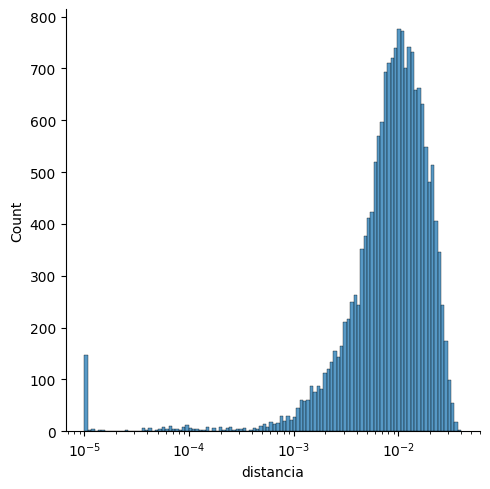

In [378]:
sns.displot(merged_distancia_lugares_culturales.distancia.apply(lambda x: x+1e-5), log_scale=True)

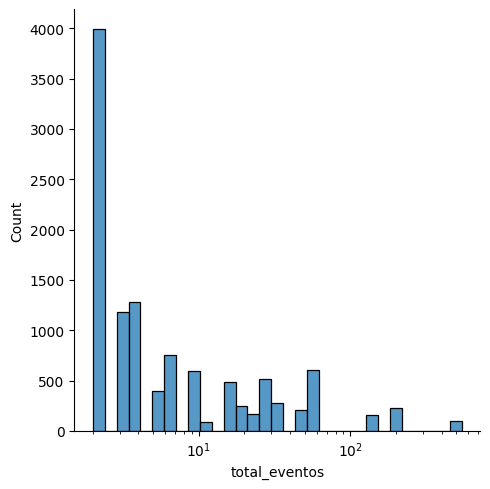

In [379]:
sns.displot(merged_distancia_lugares_culturales[merged_distancia_lugares_culturales.total_eventos > 1].total_eventos, log_scale=True)

La distribucion de cantidad de eventos es muy despareja, con lo cual contemplar quintiles a priori va a obligar a tomar pocos deciles (3 o 4?)

In [380]:
pd.qcut(merged_distancia_lugares_culturales[merged_distancia_lugares_culturales.total_eventos > 1].total_eventos, q=4, duplicates="drop").value_counts()

(1.999, 4.0]     6456
(16.0, 542.0]    2732
(4.0, 16.0]      2126
Name: total_eventos, dtype: int64

In [381]:
# para scorear la disponibilidad de eventos culturales, voy a tomar el producto entre el quintil en la distancia al lugar y el quintil del total de eventos
merged_distancia_lugares_culturales["quintil_distancia"] = pd.qcut(merged_distancia_lugares_culturales.distancia.apply(lambda x: 1/(x+1e-4)), 5, labels=False) + 1 # agrego un offset para evitar que haya distancias de 0
merged_distancia_lugares_culturales["score_total_eventos"] = pd.qcut(merged_distancia_lugares_culturales.total_eventos, 5, labels=False, duplicates="drop") + 1 # no es un quintil porque no está parejamente dividido
merged_distancia_lugares_culturales["score_eventos_culturales"] = merged_distancia_lugares_culturales.quintil_distancia * merged_distancia_lugares_culturales.score_total_eventos

merged_distancia_lugares_culturales.quintil_distancia.value_counts(), merged_distancia_lugares_culturales.score_total_eventos.value_counts()

(4    3554
 2    3554
 1    3554
 3    3554
 5    3554
 Name: quintil_distancia, dtype: int64,
 1    10448
 4     3493
 3     2646
 2     1183
 Name: score_total_eventos, dtype: int64)

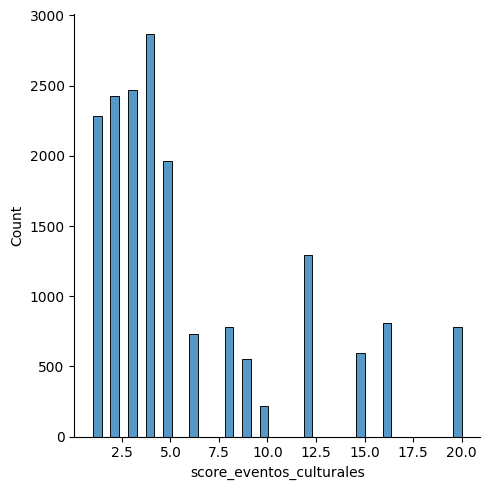

In [382]:
sns.displot(merged_distancia_lugares_culturales.score_eventos_culturales)

<Axes: >

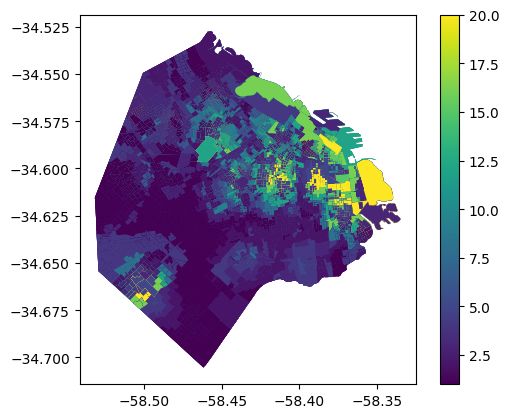

In [385]:
merged_distancia_lugares_culturales.set_geometry("geometry_ciudad").plot(column="score_eventos_culturales", legend=True)

In [386]:
merged_distancia_lugares_culturales.head()

ID                                    geometry_ciudad CO_FRAC_RA  \
41323  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41232  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41213  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41315  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   
41278  285  MULTIPOLYGON (((-58.49614 -34.62142, -58.49712...    10_10_1   

                       lugar               geometry_lugar  distancia  \
41323  ESCUELA IES J.B.JUSTO  POINT (-58.49509 -34.61408)   0.005033   
41232  PLAZA VELEZ SARSFIELD  POINT (-58.48281 -34.62951)   0.014995   
41213         CAFÉ DE GARCÍA  POINT (-58.51059 -34.60636)   0.019466   
41315      SALA CAFE ARTIGAS  POINT (-58.47518 -34.61024)   0.021505   
41278    club Comunicaciones  POINT (-58.48979 -34.59717)   0.022641   

       index_right  total_eventos  actividad_joven  perc_total_eventos  \
41323          112              1                1            0.000619   
41232          103              1                0            0.000619   
41213          119              1                0            0.000619   
41315          107              1                0            0.000619   
41278          107              1                0            0.000619   

       perc_actividades_jovenes  quintil_distancia  score_total_eventos  \
41323                  0.001139                  4                    1   
41232                  0.000000                  2                    1   
41213                  0.000000                  1                    1   
41315                  0.000000                  1                    1   
41278                  0.000000                  1                    1   

       score_eventos_culturales  
41323                         4  
41232                         2  
41213                         1  
41315                         1  
41278                         1

In [391]:
# para obtener un único score por CO_FRAC_RA, voy a tomar la suma de los scores de los lugares culturales
indicador_cultura_por_radio = merged_distancia_lugares_culturales.groupby("CO_FRAC_RA").agg({"score_eventos_culturales": "sum"}).reset_index()
indicador_cultura_por_radio["quintil_indicador_cultura"] = pd.qcut(indicador_cultura_por_radio.score_eventos_culturales, 10, labels=False, duplicates="drop") + 1
# add geometry column by merging with radios censales in ciudad_gpd
indicador_cultura_por_radio = ciudad_gpd[["CO_FRAC_RA", "geometry"]].merge(indicador_cultura_por_radio, how="left", on="CO_FRAC_RA")
# convert to geodataframe
indicador_cultura_por_radio = gpd.GeoDataFrame(indicador_cultura_por_radio, geometry="geometry")
indicador_cultura_por_radio.set_crs(epsg=4326, inplace=True)
indicador_cultura_por_radio.head()

CO_FRAC_RA                                           geometry  \
0      1_1_1  MULTIPOLYGON (((-58.37249 -34.59155, -58.37261...   
1     1_12_1  MULTIPOLYGON (((-58.38652 -34.60399, -58.38634...   
2    1_12_10  MULTIPOLYGON (((-58.37938 -34.60484, -58.37801...   
3    1_12_11  MULTIPOLYGON (((-58.36792 -34.60517, -58.36772...   
4     1_12_2  MULTIPOLYGON (((-58.38513 -34.60391, -58.38371...   

   score_eventos_culturales  quintil_indicador_cultura  
0                        59                         10  
1                        70                         10  
2                        55                          9  
3                        65                         10  
4                        25                          5

<Axes: >

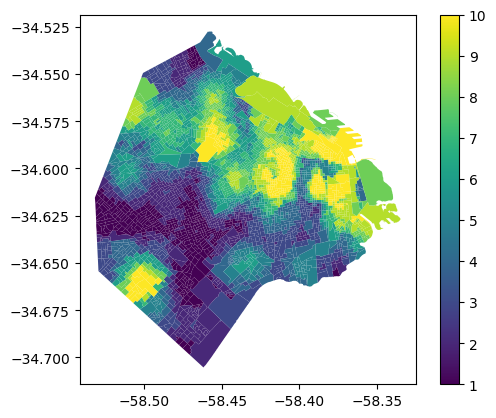

In [392]:
indicador_cultura_por_radio.plot(column="quintil_indicador_cultura", legend=True)

In [393]:
indicador_cultura_por_radio

CO_FRAC_RA                                           geometry  \
0         1_1_1  MULTIPOLYGON (((-58.37249 -34.59155, -58.37261...   
1        1_12_1  MULTIPOLYGON (((-58.38652 -34.60399, -58.38634...   
2       1_12_10  MULTIPOLYGON (((-58.37938 -34.60484, -58.37801...   
3       1_12_11  MULTIPOLYGON (((-58.36792 -34.60517, -58.36772...   
4        1_12_2  MULTIPOLYGON (((-58.38513 -34.60391, -58.38371...   
...         ...                                                ...   
3549     1_3_12  MULTIPOLYGON (((-58.38212 -34.58430, -58.38125...   
3550     1_3_11  MULTIPOLYGON (((-58.38119 -34.58483, -58.38002...   
3551     1_3_10  MULTIPOLYGON (((-58.38086 -34.58431, -58.38047...   
3552    7_18_11  MULTIPOLYGON (((-58.43532 -34.64905, -58.43496...   
3553     7_18_9  MULTIPOLYGON (((-58.43052 -34.64981, -58.43043...   

      score_eventos_culturales  quintil_indicador_cultura  
0                           59                         10  
1                           70                         10  
2                           55                          9  
3                           65                         10  
4                           25                          5  
...                        ...                        ...  
3549                        66                         10  
3550                        80                         10  
3551                        66                         10  
3552                        27                          6  
3553                        29                          6  

[3554 rows x 4 columns]

In [399]:
distancia_a_juegotecas.shape

(3554, 18)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3554 entries, 0 to 3553
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   CO_FRAC_RA                       3554 non-null   object  
 1   geometry                         3554 non-null   geometry
 2   quintil_distancia_juegoteca      3554 non-null   int64   
 3   quintil_distancia_polideportivo  3554 non-null   int64   
 4   quintil_indicador_cultura        3554 non-null   int64   
dtypes: geometry(1), int64(3), object(1)
memory usage: 166.6+ KB


<Axes: >

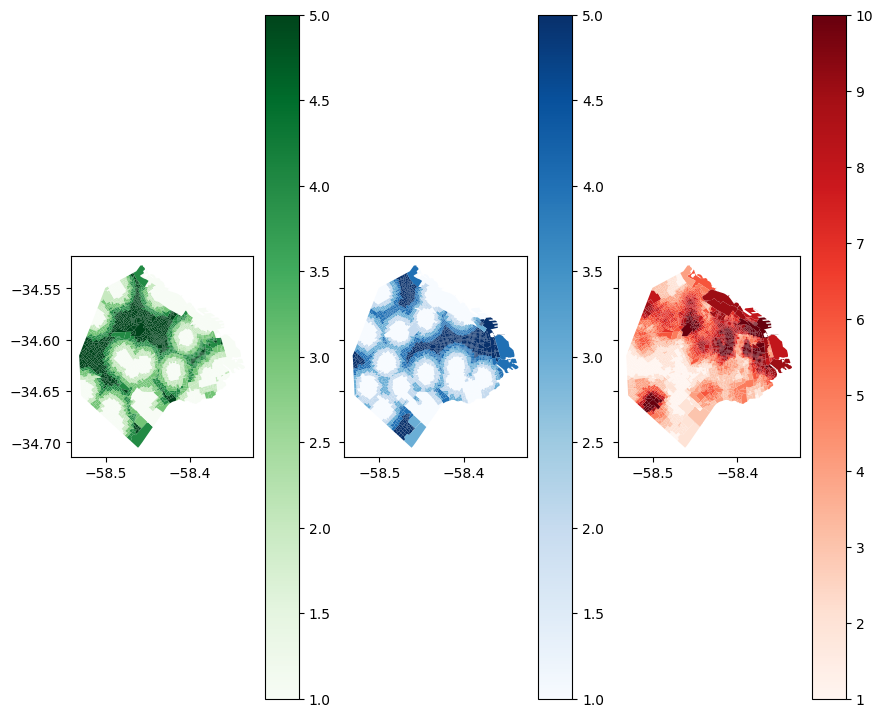

In [401]:
# junto con polideportivos y juegotecas para armar data total
agged_scores_cultura = pd.merge(distancia_a_juegotecas[["CO_FRAC_RA", "geometry", "quintil_distancia_juegoteca"]],
         distancia_a_polideportivos[["CO_FRAC_RA", "geometry", "quintil_distancia_polideportivo"]],
            on=["CO_FRAC_RA", "geometry"])

# merge with indicador_cultura_por_radio
agged_scores_cultura = pd.merge(agged_scores_cultura, indicador_cultura_por_radio[["CO_FRAC_RA", "geometry", "quintil_indicador_cultura"]],
                                on=["CO_FRAC_RA", "geometry"])

agged_scores_cultura.info()

# convert to geodataframe
agged_scores_cultura = gpd.GeoDataFrame(agged_scores_cultura, geometry="geometry")
agged_scores_cultura.set_crs(epsg=4326, inplace=True)

# plot the 3 inficators
fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)

agged_scores_cultura.plot(column="quintil_distancia_juegoteca", legend=True, ax=ax[0], cmap="Greens")
agged_scores_cultura.plot(column="quintil_distancia_polideportivo", legend=True, ax=ax[1], cmap="Blues")
agged_scores_cultura.plot(column="quintil_indicador_cultura", legend=True, ax=ax[2], cmap="Reds")

In [403]:
# save to app path
agged_scores_cultura.to_file(os.path.join("src/data/final", "indicadores_cultura.geojson"), driver="GeoJSON")